Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/drive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.getcwd()

'/content'

In [ ]:
os.listdir()
os.chdir('/content/drive/MyDrive/CNN Data')
os.listdir()

['Test', 'Train', 'model_plot.png']

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(os.getcwd()+'/Train')
data_dir_test = pathlib.Path(os.getcwd()+'/Test')

In [ ]:
data_dir_test.exists()


True

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset='training'
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset='validation'
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)
print(len(class_names))

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
9


In [ ]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

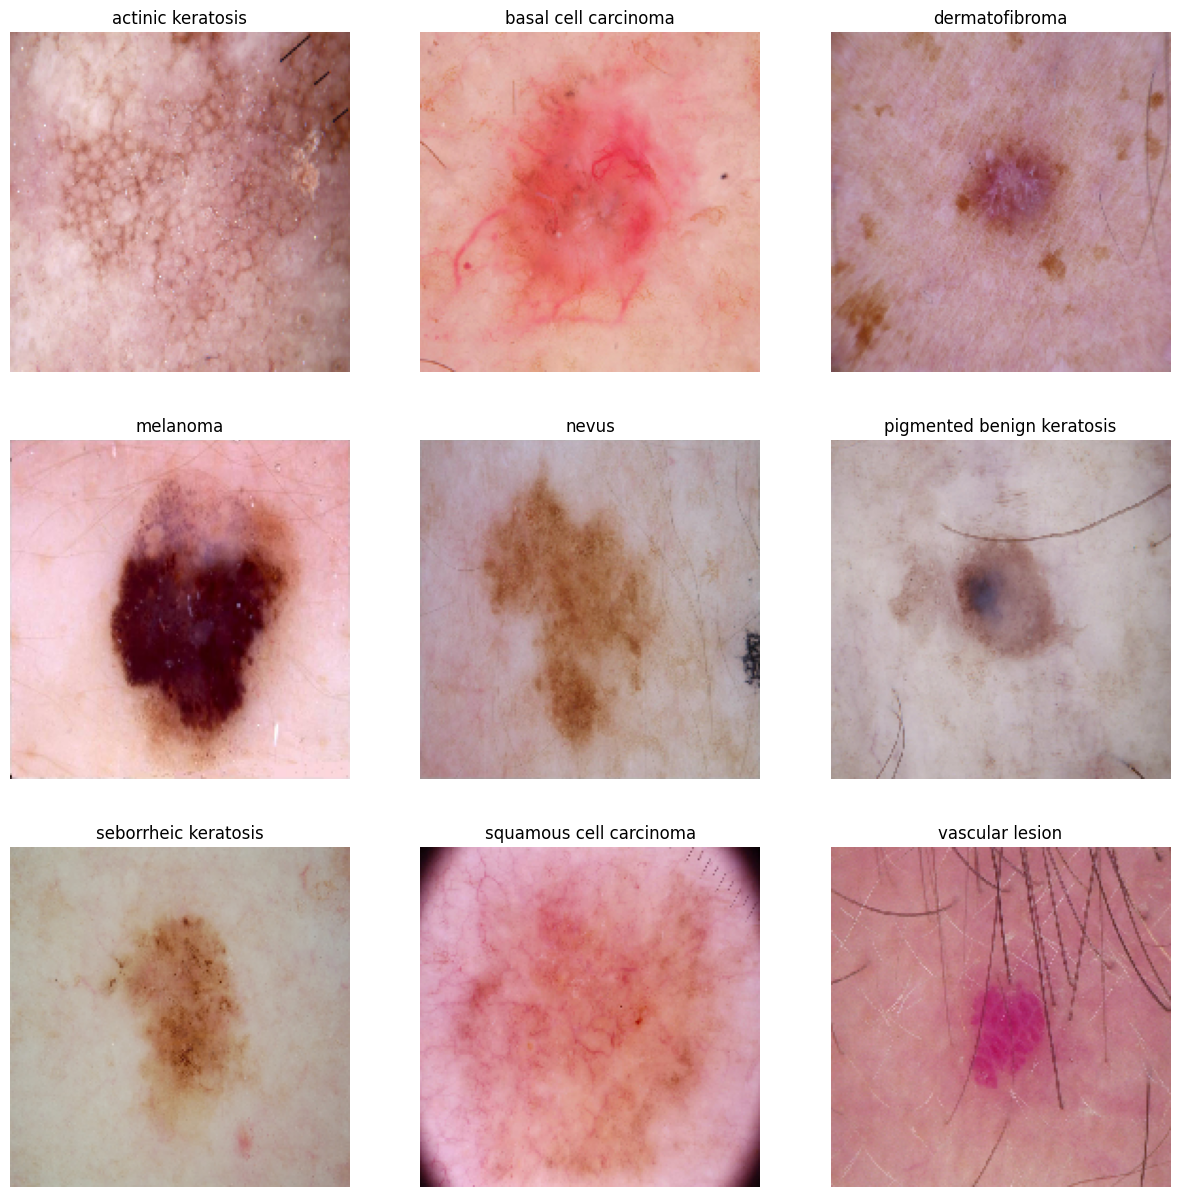

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
### your code goes here, you can use training or validation data to visualize
#Visualize image

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32, 9)


### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
##rescaling the layers
normalization_layer = layers.Rescaling(1./255)

In [ ]:
##mapping normalization to all the images
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.020586843 0.8244621


In [ ]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))


#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))


#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))



### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

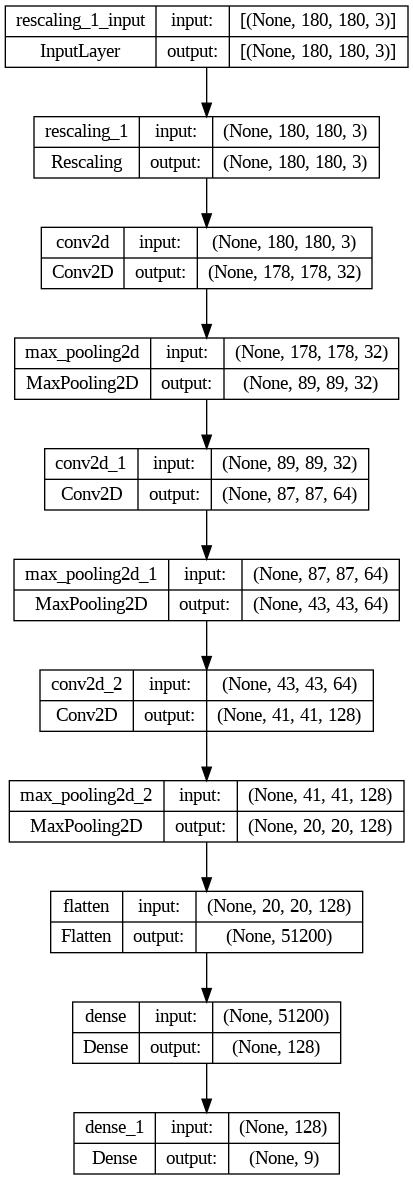

In [ ]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 90s 1s/step - loss: 2.0151 - accuracy: 0.2634 - val_loss: 1.6997 - val_accuracy: 0.3669
Epoch 2/20
56/56 [==============================] - 2s 33ms/step - loss: 1.6054 - accuracy: 0.4381 - val_loss: 1.6312 - val_accuracy: 0.3893
Epoch 3/20
56/56 [==============================] - 2s 37ms/step - loss: 1.4623 - accuracy: 0.4922 - val_loss: 1.4546 - val_accuracy: 0.5101
Epoch 4/20
56/56 [==============================] - 2s 35ms/step - loss: 1.3607 - accuracy: 0.5195 - val_loss: 1.4073 - val_accuracy: 0.5168
Epoch 5/20
56/56 [==============================] - 2s 34ms/step - loss: 1.2735 - accuracy: 0.5485 - val_loss: 1.3669 - val_accuracy: 0.5235
Epoch 6/20
56/56 [==============================] - 2s 34ms/step - loss: 1.2150 - accuracy: 0.5731 - val_loss: 1.3666 - val_accuracy: 0.5414
Epoch 7/20
56/56 [==============================] - 2s 34ms/step - loss: 1.1397 - accuracy: 0.6027 - val_loss: 1.8710 - val_accuracy: 0.4564
Epoch 8/20
56/

### Visualizing training results

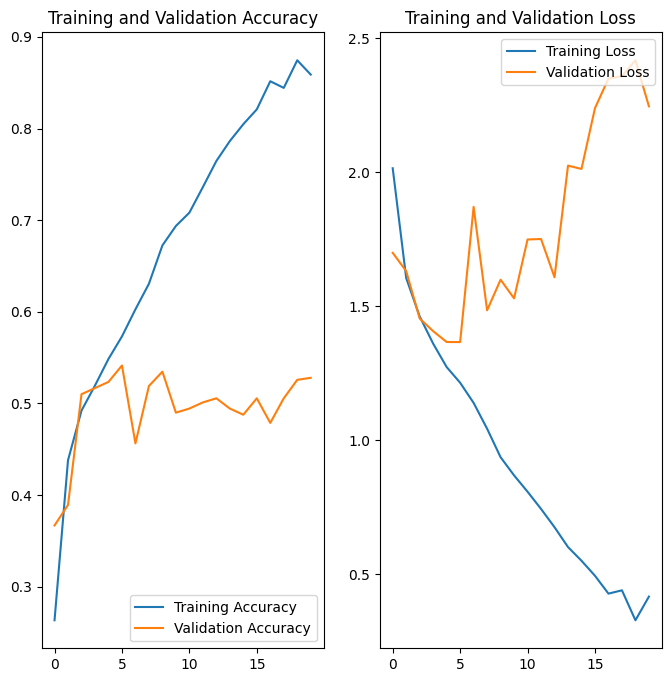

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
##### Model accuracy did not improve above 57% in the validation, Moreover model is highly overfit due to the fact that there is a huge difference in accuracies of training and validation sets of the data. We need to augments / re-sample the data to make it more balanced and regularise the model too to make it fit better and reduce parameters.

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
## data augmnentation CNN input data , adding randomized data points from the exisiting set of images, by changing it orientation, zoom, rotation etc.
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(180,
                                  180,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

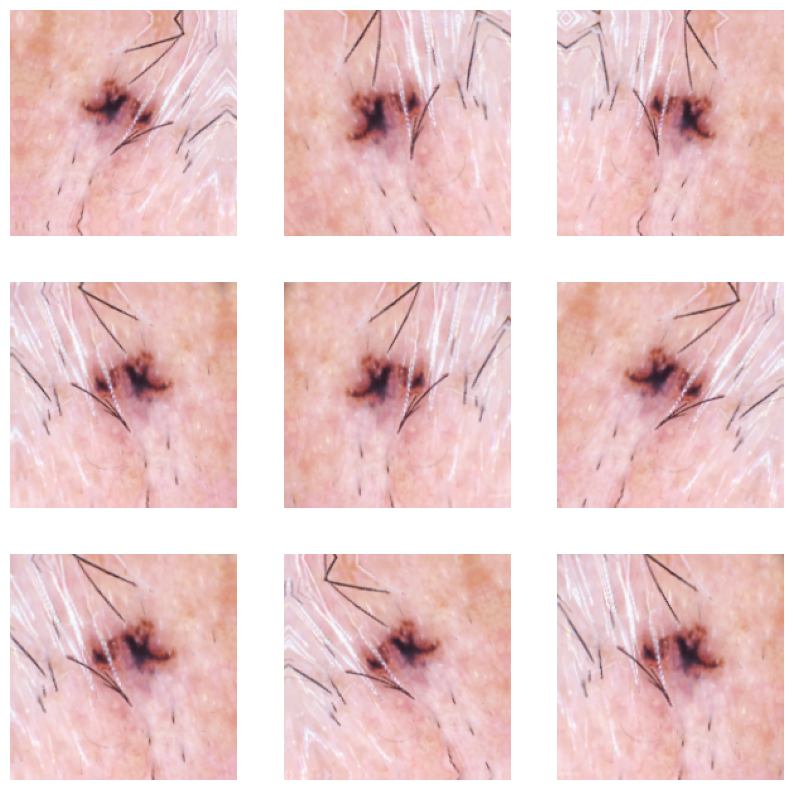

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Below has different augmentation for the single image from the training data set to increase the size of the data
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
#CNN Model Architecture
from keras.regularizers import l2

#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu',))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu',kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001)))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))




### Compiling the model

In [ ]:
## Your code goes here
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

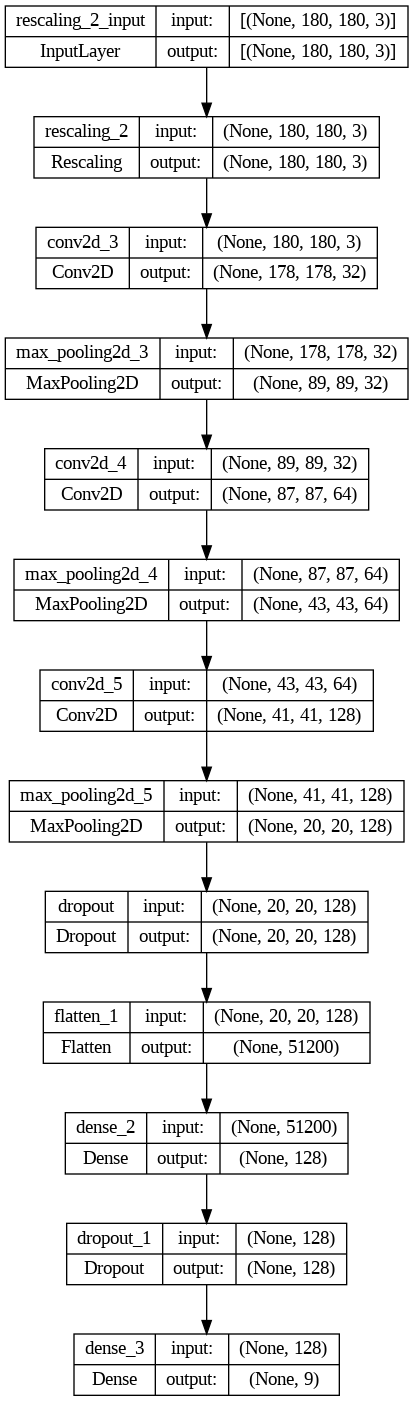

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 57ms/step - loss: 2.0892 - accuracy: 0.2327 - val_loss: 1.8118 - val_accuracy: 0.3803
Epoch 2/20
56/56 [==============================] - 3s 54ms/step - loss: 1.7506 - accuracy: 0.3850 - val_loss: 1.6094 - val_accuracy: 0.4318
Epoch 3/20
56/56 [==============================] - 3s 57ms/step - loss: 1.6350 - accuracy: 0.4308 - val_loss: 1.5391 - val_accuracy: 0.4989
Epoch 4/20
56/56 [==============================] - 3s 55ms/step - loss: 1.4941 - accuracy: 0.4872 - val_loss: 1.4818 - val_accuracy: 0.5034
Epoch 5/20
56/56 [==============================] - 3s 54ms/step - loss: 1.4448 - accuracy: 0.5039 - val_loss: 1.4250 - val_accuracy: 0.5123
Epoch 6/20
56/56 [==============================] - 3s 54ms/step - loss: 1.4085 - accuracy: 0.5151 - val_loss: 1.4457 - val_accuracy: 0.5324
Epoch 7/20
56/56 [==============================] - 3s 55ms/step - loss: 1.3399 - accuracy: 0.5318 - val_loss: 1.4045 - val_accuracy: 0.5235
Epoch 8/20
56

### Visualizing the results

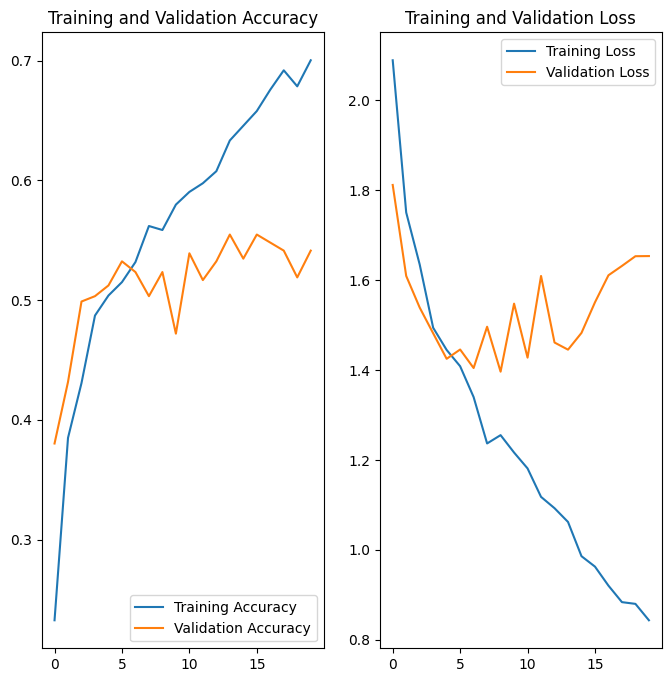

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?
##### Model's accuracy has come down for the training set too, but it is still overfitting to an extent, which needs further data augmentation to get the better results

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Axes: >

<Figure size 1500x1500 with 0 Axes>

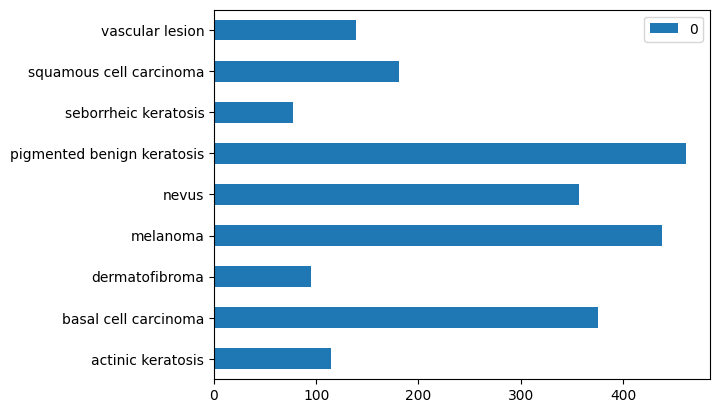

In [ ]:
## Your code goes here.
## check for class imbalance
## Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

files_len = {key:len(value) for key,value in files_path_dict.items()}

files_len=df=pd.DataFrame.from_dict(files_len,orient = 'index')
plt.figure(figsize=(15,15))
files_len.plot(kind='barh')



In [ ]:
files_len

,0
actinic keratosis,114
basal cell carcinoma,376
dermatofibroma,95
melanoma,438
nevus,357
pigmented benign keratosis,462
seborrheic keratosis,77
squamous cell carcinoma,181
vascular lesion,139


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
###### - seborrheic keratosis has the least number of samples in it
#### - Which classes dominate the data in terms proportionate number of samples?
###### - Pigmented benign keratosis and melanoma dominate the proportion of samples in the dataset


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset=os.getcwd()+'/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Data/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C010BD335B0>: 100%|██████████| 500/500 [00:23<00:00, 20.88 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Data/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C010BDA2D70>: 100%|██████████| 500/500 [00:19<00:00, 25.14 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C0170A4E020>: 100%|██████████| 500/500 [00:19<00:00, 26.26 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7C017016BCD0>: 100%|██████████| 500/500 [01:36<00:00,  5.20 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Data/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C01709A5A50>: 100%|██████████| 500/500 [01:26<00:00,  5.76 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C0170BEE530>: 100%|██████████| 500/500 [00:19<00:00, 25.32 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C0124B7F310>: 100%|██████████| 500/500 [00:37<00:00, 13.24 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C01709B0190>: 100%|██████████| 500/500 [00:17<00:00, 27.99 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Data/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C010BD2DD80>: 100%|██████████| 500/500 [00:19<00:00, 25.77 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
data_dir_train

PosixPath('/content/drive/MyDrive/CNN Data/Train')

In [ ]:
import glob
path_list_new= [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/drive/MyDrive/CNN Data/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025627.jpg_b28f0b62-b6ac-4ad1-9528-f70703d8f50c.jpg',
 '/content/drive/MyDrive/CNN Data/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027612.jpg_a07cf499-ec1a-4eef-b8e7-6bbd26b0f16f.jpg',
 '/content/drive/MyDrive/CNN Data/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028451.jpg_27d127f7-a0c7-471e-b9ab-58334545bc56.jpg',
 '/content/drive/MyDrive/CNN Data/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025275.jpg_3d924dff-b05d-40b1-a47f-806368a1c3fa.jpg',
 '/content/drive/MyDrive/CNN Data/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027735.jpg_7d10c594-2308-4945-8b55-475c9af22a60.jpg',
 '/content/drive/MyDrive/CNN Data/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028120.jpg_0eeade4d-9433-4b50-b5a8

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmen

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
data_dir_train

PosixPath('/content/drive/MyDrive/CNN Data/Train')

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train=pathlib.Path(os.getcwd()+'/Train')
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:** Create your model (make sure to include normalization)

In [118]:
## your code goes here
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
#model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
#model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))
#model.add(layers.Dropout(0.25))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
#model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Fourth Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
#model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [119]:
## your code goes here
model.compile(optimizer="Adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [120]:

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_24 (Conv2D)          (None, 41, 41, 128)      

#### **Todo:**  Train your model

In [ ]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [121]:
epochs = 30
## Your code goes here, use 30 epochs.
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/30
169/169 [==============================] - 11s 54ms/step - loss: 1.9535 - accuracy: 0.2365 - val_loss: 1.6499 - val_accuracy: 0.3994
Epoch 2/30
169/169 [==============================] - 9s 51ms/step - loss: 1.6834 - accuracy: 0.3596 - val_loss: 1.5387 - val_accuracy: 0.4053
Epoch 3/30
169/169 [==============================] - 9s 50ms/step - loss: 1.4906 - accuracy: 0.4210 - val_loss: 1.4343 - val_accuracy: 0.4358
Epoch 4/30
169/169 [==============================] - 9s 51ms/step - loss: 1.4003 - accuracy: 0.4651 - val_loss: 1.3268 - val_accuracy: 0.4774
Epoch 5/30
169/169 [==============================] - 9s 52ms/step - loss: 1.3234 - accuracy: 0.5004 - val_loss: 1.2256 - val_accuracy: 0.5226
Epoch 6/30
169/169 [==============================] - 8s 49ms/step - loss: 1.2221 - accuracy: 0.5345 - val_loss: 1.1516 - val_accuracy: 0.5501
Epoch 7/30
169/169 [==============================] - 9s 51ms/step - loss: 1.1649 - accuracy: 0.5675 - val_loss: 1.0985 - val_accuracy: 0.588

#### **Todo:**  Visualize the model results

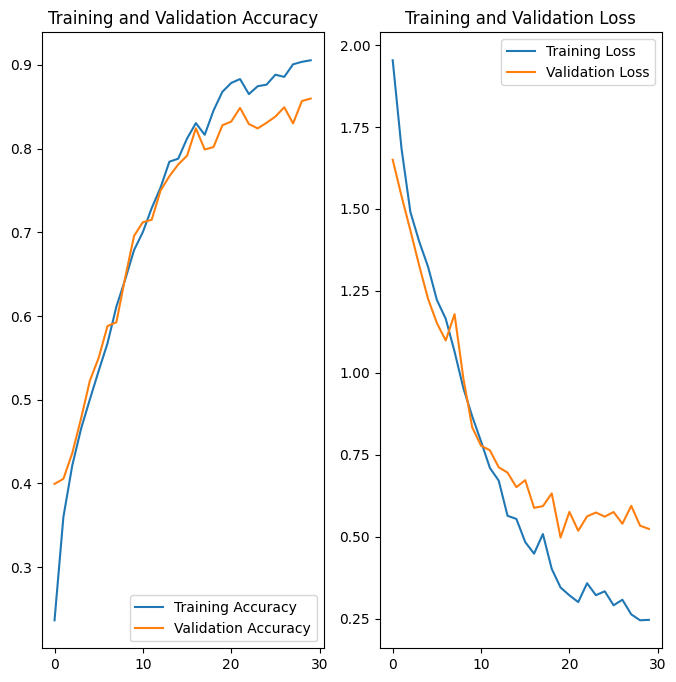

In [122]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [ ]:
for cls in class_names:
  Test_image_path = os.path.join(data_dir_test, cls, '*')
  Test_image = glob.glob(Test_image_path)
  for img in Test_image:
    Test_image = load_img(img,target_size=(180,180,3))
    plt.imshow(Test_image)
    plt.grid(False)
    img = np.expand_dims(Test_image,axis=0)
    pred = model.predict(img)
    pred = np.argmax(pred)
    pred_class = class_names[pred]
    print("Actual Class "+ cls +'\n'+ "Predictive Class "+pred_class )
    plt.show()

In [123]:
act_list=[]
pred_list=[]
for cls in class_names:
  Test_image_path = os.path.join(data_dir_test, cls, '*')
  Test_image = glob.glob(Test_image_path)
  for img in Test_image:
    Test_image = load_img(img,target_size=(180,180,3))
    imgg = np.expand_dims(Test_image,axis=0)
    pred = model.predict(imgg)
    pred = np.argmax(pred)
    pred_class = class_names[pred]
    #print(zip(cls,pred_class))
    act_list.append(cls)
    pred_list.append(pred_class)
    #pred_table=pred_table.append(dataframe)

1/1 [==============================] - 0s 18ms/step


In [124]:
final_df=pd.DataFrame(zip(act_list,pred_list))
final_df.columns=['Actual','Predicted']

In [125]:
## Accuracy
final_df['Tag']=np.where(final_df['Actual']==final_df['Predicted'],1,0)
final_df['Tag'].sum()/final_df.shape[0]

0.3559322033898305

In [126]:
## We have only around 35% accuracy on the Test set